In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from DomainPrediction.utils import helper

In [4]:
data_path = '../../../Data/al_test_experiments/Evolvepro'

In [5]:
file = os.path.join(data_path, 'brenan.csv')
df = pd.read_csv(file)

In [6]:
df.head()

,pos,mutant,seq,function,function_scaled
0,2,A2C,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.176315,0.265834
1,2,A2D,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-1.918793,0.397712
2,2,A2E,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-3.165665,0.324874
3,2,A2F,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-6.126452,0.151913
4,2,A2G,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.255602,0.261203


In [7]:
wt = helper.read_fasta(os.path.join(data_path, 'brenan_WT.fasta'), mode='str')[0]

In [8]:
## sanity check againts wlldtype
for i, row in df.iterrows():
    pos = row["pos"]
    assert wt[pos-1] == row['mutant'][0]

In [9]:
df_new = df.copy()
df_new.columns = ['pos', 'variant', 'seq', 'fitness_raw', 'fitness_norm']

In [10]:
df_new.head()

,pos,variant,seq,fitness_raw,fitness_norm
0,2,A2C,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.176315,0.265834
1,2,A2D,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-1.918793,0.397712
2,2,A2E,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-3.165665,0.324874
3,2,A2F,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-6.126452,0.151913
4,2,A2G,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.255602,0.261203


In [11]:
df_new['wt_aa'] = df_new['variant'].apply(lambda x: x[0])
df_new['n_mut'] = 1

In [12]:
df_new.head()

,pos,variant,seq,fitness_raw,fitness_norm,wt_aa,n_mut
0,2,A2C,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.176315,0.265834,A,1
1,2,A2D,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-1.918793,0.397712,A,1
2,2,A2E,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-3.165665,0.324874,A,1
3,2,A2F,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-6.126452,0.151913,A,1
4,2,A2G,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.255602,0.261203,A,1


In [13]:
## sanity check for n mutants
for i, row in df_new.iterrows():
    variant_seq = row["seq"]
    assert len(variant_seq) == len(wt)
    n = 0
    for a, b in zip(variant_seq, wt):
        if a != b:
            n += 1
    
    assert n == row['n_mut']

#### Data splits

In [14]:
np.random.seed(0)

In [16]:
n_folds = 10
positions = df_new['pos'].unique()
blocks = np.array_split(positions, n_folds)

assert sum(len(i) for i in blocks) == len(positions)

df_new['fold_id'] = -1
for i, _pos in enumerate(blocks):
    assert (df_new.loc[df_new['pos'].isin(_pos), 'fold_id'] == -1).all()
    df_new.loc[df_new['pos'].isin(_pos), 'fold_id'] = i

assert ~((df_new['fold_id'] == -1).any())

test_fold = [2, 6]
val_fold = [8]

df_new['split_id'] = -1
df_new.loc[df_new['fold_id'].isin(test_fold), 'split_id'] = 0
df_new.loc[df_new['fold_id'].isin(val_fold), 'split_id'] = 1
df_new.loc[~df_new['fold_id'].isin(test_fold+val_fold), 'split_id'] = 2

assert ~((df_new['split_id'] == -1).any())

In [17]:
df_new.head()

,pos,variant,seq,fitness_raw,fitness_norm,wt_aa,n_mut,fold_id,split_id
0,2,A2C,MCAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.176315,0.265834,A,1,0,2
1,2,A2D,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-1.918793,0.397712,A,1,0,2
2,2,A2E,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-3.165665,0.324874,A,1,0,2
3,2,A2F,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-6.126452,0.151913,A,1,0,2
4,2,A2G,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...,-4.255602,0.261203,A,1,0,2


In [24]:
file = os.path.join(data_path, 'dataset_brenen.csv')
df_new.to_csv(file, index=False)

In [27]:
file = os.path.join(data_path, 'dataset_brenen.csv')
df_new = pd.read_csv(file)

Text(0.5, 1.0, 'Test')

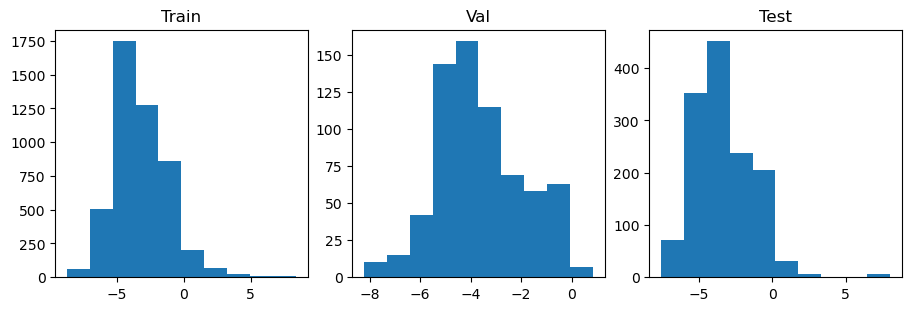

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_raw'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_raw'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_raw'])
# ax[0].set_xlim(-10,10)
# ax[1].set_xlim(-10,10)
# ax[2].set_xlim(-10,10)
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')

Text(0.5, 1.0, 'Test')

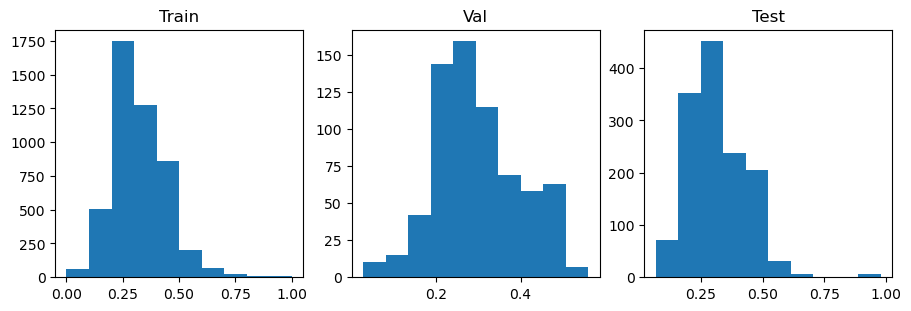

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_norm'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_norm'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_norm'])
# ax[0].set_xlim(-10,10)
# ax[1].set_xlim(-10,10)
# ax[2].set_xlim(-10,10)
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')